## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shap
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Run the data preparation notebook
testdf = np.load("npy_files/X_analog_feb_july.npy", allow_pickle=True)

X_analog = testdf[:,:-2].astype(np.float32)
anomaly_list = testdf[:,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:,-2]
timestamps = pd.to_datetime(timestamps)


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_analog.shape

(9665, 16)

In [3]:
pd.DataFrame(X_analog[0,:]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.642,9.736,9.728,9.32,8.926,8.558,8.228,6.05,6.15,3.855,0.04,0.04,0.04,0.0375,109.0,1942.0


#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [4]:
# Define input dimension
input_dim = X_analog.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

## Running the Autoencoder

#### Operator to tell the first cycle of a given month

In [5]:
np.where(timestamps.month == 4)[0][0]

np.int64(2954)

#### Boundary condition: the primordial run

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 62.7411 - val_loss: 39.9182
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.0720 - val_loss: 37.0388
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2695 - val_loss: 32.8992
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5984 - val_loss: 29.1160
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7765 - val_loss: 25.9993
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4787 - val_loss: 23.6958
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5036 - val_loss: 22.0774
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7479 - val_loss: 20.8103
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1526 - val_loss: 19.8560
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6715 - val_loss: 19.0953
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2794 - val_loss: 18.4781
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

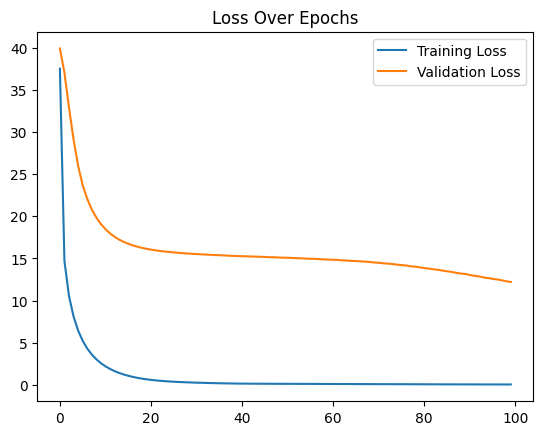

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Threshold:  0.16400963
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
pred_aux: (array([False,  True]), array([ 65, 238]))


In [6]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_analog

#new variables for the moving window problem
test_loss = []
preds_list = []
val_preds_list = []
threshold_list = []

normal_train_data = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, 16), dtype=np.float32)
normal_val_data = np.empty((0, 16), dtype=np.float32)
anomalous_val_data = np.empty((0, 16), dtype=np.float32)


test_cycle_normalized = np.empty((1, 16), dtype=np.float32)
test_cycle = np.empty((1, 16), dtype=np.float32)
good_cycles = np.empty((1,16), dtype=np.float32)


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
index_mar = 1180+1 #March 1st index (+1 bc 1st cycle is problematic)
index_apr = 2954
index_mai = 4193 
index_jun = 5815
index_jul = 7611
time_delta = 7 # how many days at a time you want to test
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set
last_test_index2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=2*time_delta))

# Split the data and labels
train_data = data[index_mar:index_apr].astype(np.float32)
val_data = data[index_apr:last_test_index]
test_data = data[last_test_index:last_test_index2].astype(np.float32) # Assuring we only test 1 week at a time

train_labels = labels[index_mar:index_apr]
val_labels = labels[index_apr:last_test_index]
test_labels = labels[last_test_index:last_test_index2] # Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)


normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)
val_data_normalized = np.zeros_like(val_data)
normal_val_data_normalized = np.zeros_like(normal_val_data)



scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()
val_data_normalized[:, 14] = scaler.transform(val_data[:, 14].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()
val_data_normalized[:, 15] = scaler.transform(val_data[:, 15].reshape(-1, 1)).flatten()


#Separate into normal and anomalous data
for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)


# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30,
    validation_data=(normal_val_data_normalized, normal_val_data_normalized)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_val = autoencoder.predict(val_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

if 1 in val_labels:
    y_true = (np.array(val_labels) != 0).astype(int)
    scores = np.array(val_loss)

    # 1. Calculate precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve(y_true, scores)

    # Note: precision and recall arrays have one extra element compared to thresholds.
    # We'll compute F1 scores for the thresholds only.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
    # 2. Identify the best threshold (maximizing F1 score)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
else:
    # Compute the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(val_loss, 25)
    Q3 = np.percentile(val_loss, 75)
    IQR = Q3 - Q1
    # Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
    k = 8
    best_threshold = Q3 + k * IQR

threshold_list.append(best_threshold)
print("Threshold: ", best_threshold)



# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy()
preds_list = np.concatenate((preds_list, pred_aux), axis=0)
pred_val_aux = val_labels #predict(autoencoder, normal_val_data_normalized, best_threshold)
val_preds_list = np.concatenate((val_preds_list, pred_val_aux), axis=0)
print("pred_aux:", np.unique(pred_aux, return_counts=True))

test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())


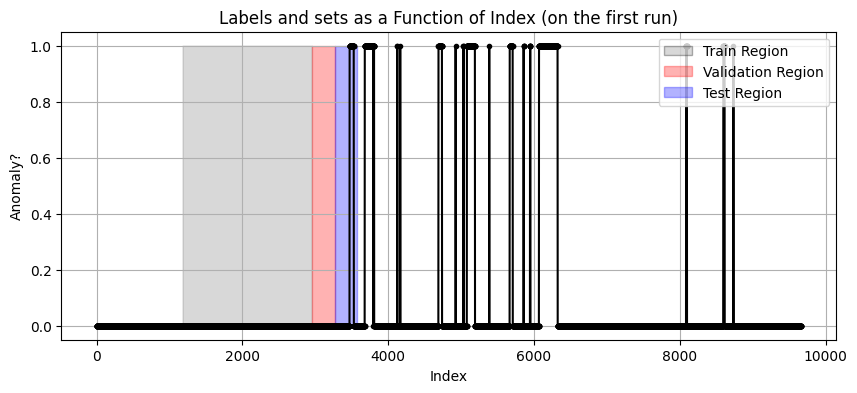

In [7]:
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, '.-', color='black', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_mar) & (np.arange(len(labels)) < index_apr), color='gray', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_apr) & (np.arange(len(labels)) < last_test_index), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= last_test_index)& (np.arange(len(labels)) < last_test_index2), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels and sets as a Function of Index (on the first run)')
plt.grid(True)
plt.show()

#### Plotting the threshold with the test sets

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


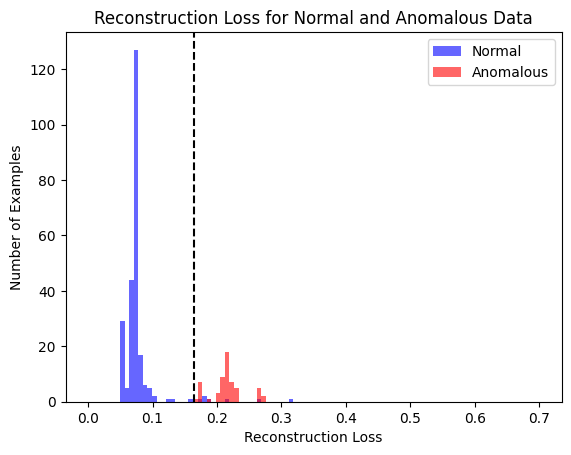

In [8]:
normal_test_data_normalized = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_test_data_normalized = np.empty((0, 16), dtype=np.float32)
for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data_normalized = np.concatenate((normal_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_test_data_normalized = np.concatenate((anomalous_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
reconstructions_test_normal = autoencoder.predict(normal_test_data_normalized)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data_normalized)

reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data_normalized)
anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data_normalized)

# Plot both losses on the same histogram
plt.hist(normal_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
plt.hist(anomalous_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous Data")
plt.axvline(x=best_threshold, color='black', linestyle='--')
#plt.ylim((0, 40))
plt.show()

#### Moving window

In [9]:
n = 1
break_flag = False

#Computing number of cycles
for j in range(len(pred_aux)):
    try:
        next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=(j+2)*time_delta))
        num_cycles = j
    except:
        break


while True:
    try:
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=(n+1)*time_delta))
        last_test_index_3 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=(n+2)*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        for j in range(len(val_labels)):
            if val_labels[j] == True:
                np.delete(normal_train_data, np.s_[:1], axis=0)
                normal_train_data = np.append(normal_train_data, [val_data[j,:]], axis=0)
        val_data = data[last_test_index:last_test_index_2]
        val_labels = labels[last_test_index:last_test_index_2]
        test_data = data[last_test_index_2:last_test_index_3]


    except:
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=(n+1)*time_delta))
        print(f"Cycle: {n}/{num_cycles+1}")
        for j in range(len(val_labels)):
            if val_labels[j] == True:
                np.delete(normal_train_data, np.s_[:1], axis=0)
                normal_train_data = np.append(normal_train_data, [val_data[j,:]], axis=0)
        val_data = data[last_test_index:last_test_index_2]
        val_labels = labels[last_test_index:last_test_index_2]
        test_data = data[last_test_index_2:]

        break_flag = True


    normal_train_data_normalized = np.zeros_like(normal_train_data)
    test_data_normalized = np.zeros_like(test_data)
    val_data_normalized = np.zeros_like(val_data)
    normal_val_data_normalized = np.empty((0, 16), dtype=np.float32)
    anomalous_val_data_normalized = np.empty((0, 16), dtype=np.float32)


    scaler = MinMaxScaler()
    normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform sensor 2 (columns 7-13)
    normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
    val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

    # Fit and transform Trun (column 14)
    normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
    test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()
    val_data_normalized[:, 14] = scaler.transform(val_data[:, 14].reshape(-1, 1)).flatten()

    # Fit and transform Tidle (column 15)
    normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
    test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()
    val_data_normalized[:, 15] = scaler.transform(val_data[:, 15].reshape(-1, 1)).flatten()


    #Separate into normal and anomalous data
    for i in range(len(val_labels)):
        if pred_aux[i] == True:
            normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
        else:
            anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)


    # Compile the model with the custom loss
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
    )

    # Train the model
    history = autoencoder.fit(
        x=normal_train_data_normalized,  # Input and target are the same for autoencoders
        y=normal_train_data_normalized,  # Input and target are the same for autoencoders
        epochs=100,#100, 
        batch_size=30,
        validation_data=(normal_val_data_normalized, normal_val_data_normalized)
    )

    ## Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
    reconstructions_val = autoencoder.predict(val_data_normalized)
    val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

    if 1 in val_labels:
        y_true = (np.array(val_labels) != 0).astype(int)
        scores = np.array(val_loss)

        # 1. Calculate precision, recall, and thresholds.
        precision, recall, thresholds = precision_recall_curve(y_true, scores)

        # Note: precision and recall arrays have one extra element compared to thresholds.
        # We'll compute F1 scores for the thresholds only.
        # F1 = 2 * (precision * recall) / (precision + recall)
        f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
        # 2. Identify the best threshold (maximizing F1 score)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
    
    else:
        # Compute the first quartile (Q1) and third quartile (Q3)
        Q1 = np.percentile(val_loss, 25)
        Q3 = np.percentile(val_loss, 75)
        IQR = Q3 - Q1
        # Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
        k = 8
        best_threshold = Q3 + k * IQR

    threshold_list.append(best_threshold)
    
    # Calculate the reconstruction loss for the anomalous test data
    pred_val_aux = pred_aux #former test set is now validation set. Use former cycle's test labels as validation labels in this cycle
    reconstructions_test = autoencoder.predict(test_data_normalized)
    pred_aux = []
    pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy().astype(bool)
    preds_list = np.concatenate((preds_list, pred_aux), axis=0)
    print("pred_aux:", np.unique(pred_aux, return_counts=True))
    print("Threshold: ", best_threshold)

    test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
    if break_flag==True:
        break
    n += 1

Cycle: 1/16
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0389 - val_loss: 0.0222
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - val_loss: 0.0205
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325 - val_loss: 0.0200
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - val_loss: 0.0196
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - val_loss: 0.0202
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - val_loss: 0.0200
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - val_loss: 0.0197
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0332 - val_loss: 0.0193
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0332 - val_loss: 0.0196
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - val_loss: 0.0199
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - val_loss: 0.0207
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

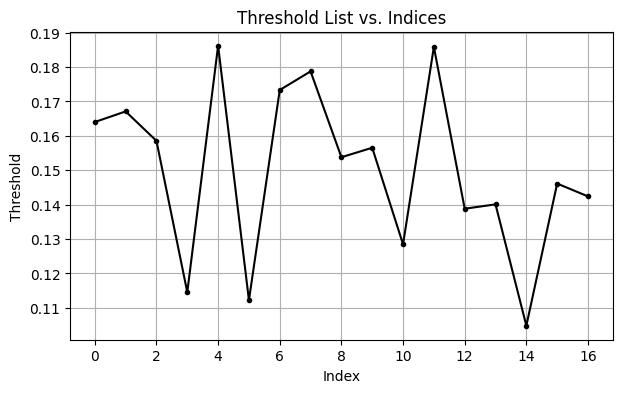

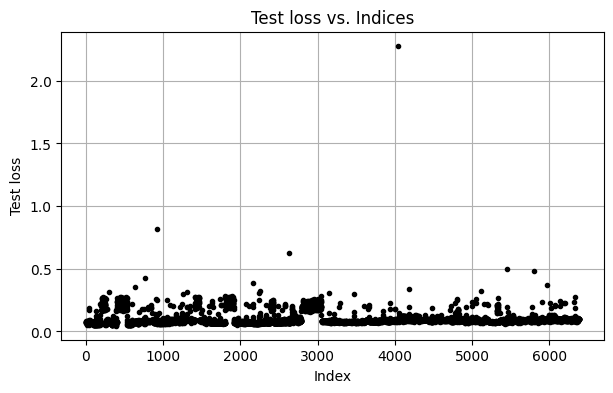

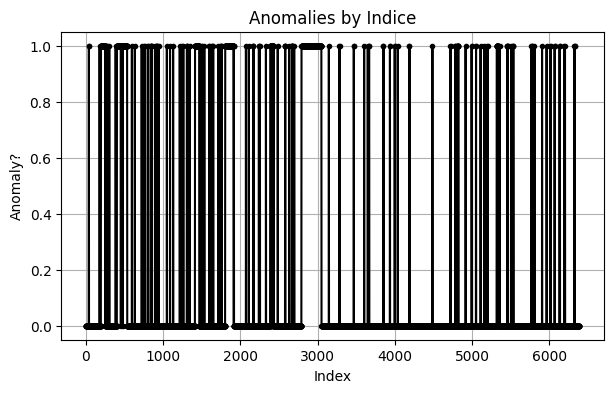

In [10]:
# Plot threshold_list against the respective indices
plt.figure(figsize=(7, 4))
plt.plot(threshold_list[:], marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)
#plt.ylim(0,0.0075)
plt.show()


# Plot test_loss against the respective indices
plt.figure(figsize=(7, 4))
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)
#plt.ylim(0,0.0075)
plt.show()



# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.figure(figsize=(7, 4))
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)
plt.show()

## Metrics and Confusion Matrix

Optimal Threshold: 0.0515
Confusion Matrix:
 [[5576  118]
 [  18  676]]
Accuracy = 97.871008140263%
Precision = 85.13853904282117%
Recall = 97.40634005763688%
F1 Score = 90.86021505376344%


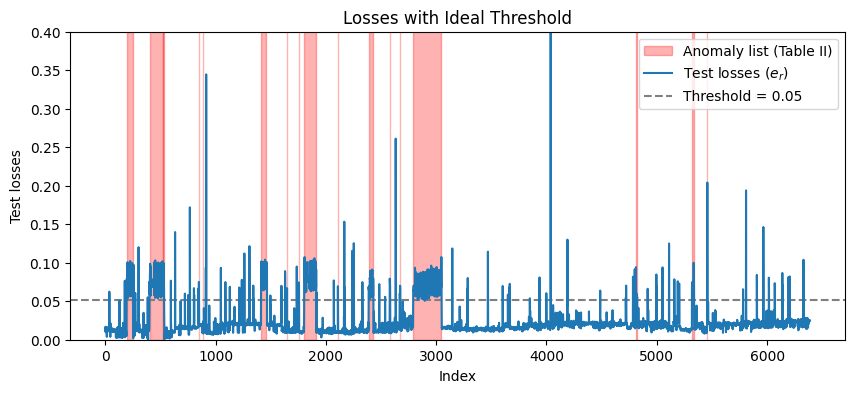

In [11]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape test_loss to a 2D array and fit and transform it
test_loss_normalized = scaler.fit_transform(np.array(test_loss).reshape(-1, 1)).flatten()
aux_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=time_delta))
anomaly_list_binary = np.array(anomaly_list[aux_index:], dtype=int)

# Function to compute F1-score for a given threshold

def compute_f1_for_threshold(threshold):
    predicted_anomalies = (test_loss_normalized >= threshold).astype(int)
    return f1_score(anomaly_list_binary, predicted_anomalies), predicted_anomalies

# Search for the best threshold
thresholds = np.linspace(0, 1, 10000)
best_threshold = max(thresholds, key=lambda t: compute_f1_for_threshold(t)[0])
best_f1, best_predictions = compute_f1_for_threshold(best_threshold)

# Compute confusion matrix
conf_matrix = confusion_matrix(anomaly_list_binary, best_predictions)

# Display results
print(f"Optimal Threshold: {best_threshold:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy = {}%".format(100*accuracy_score(anomaly_list_binary, best_predictions)))
print("Precision = {}%".format(100*precision_score(anomaly_list_binary, best_predictions, pos_label=1)))
print("Recall = {}%".format(100*recall_score(anomaly_list_binary, best_predictions, pos_label=1)))
print("F1 Score = {}%".format(100*f1_score(anomaly_list_binary, best_predictions, pos_label=1)))

# Plot the original and filtered data
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.axhline(y=best_threshold, color='gray', linestyle='--')
plt.plot(test_loss_normalized, label="Test losses ($e_r$)", linestyle='-')
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label=f"Threshold = {best_threshold:.2f}")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')
plt.title('Losses with Ideal Threshold')
plt.ylim(0,0.4)
plt.xlabel('Index')
plt.ylabel('Test losses')
plt.show()

Confusion Matrix = 
| True Negatives |     False Positives |
| -------------  |  --------------- |
| **False Negatives**   |  **True Positives** |

#### Finding out what indices are above a certain loss value

In [12]:
anomaly_detected_indices=[1 if error>0.2 else 0 for error in test_loss_normalized]
anomaly_detected_indices=np.where(anomaly_detected_indices)[0]
print(anomaly_detected_indices)

[ 915 2633 4038 5458]


### Low pass filter (LPF)

In [13]:
def low_pass_filter(data, alpha):
    y = np.zeros_like(data)
    y[0] = data[0]
    for i in range(1, len(data)):
        y[i] = y[i-1] + alpha * (data[i] - y[i-1])
    return y

#### LPF threshold set at $\tau_{LPF}=0.3$

Confusion Matrix for LPF threshold = 0.3:
[[5434  260]
 [  77  617]]

Accuracy = 94.72448340638697%
Precision = 70.35347776510832%
Recall = 88.9048991354467%
F1 Score = 78.54869509866327%


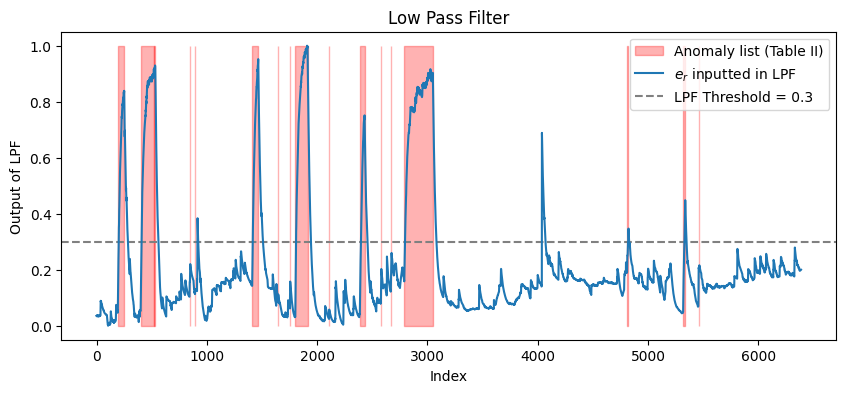

In [14]:
# Example usage
alpha = 0.04  # You can adjust this hyperparameter
lpf_output = low_pass_filter(test_loss_normalized, alpha)
lpf_output_normalized = scaler.fit_transform(np.array(lpf_output).reshape(-1, 1)).flatten()
lpf_threshold = 0.3
final_preds = []


for i in lpf_output_normalized:
    if i >= lpf_threshold:
        final_preds.append(1)
    else:
        final_preds.append(0)
        
# Ensure both lists are binary and have the same data type
anomaly_list_binary = np.array(anomaly_list[next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=time_delta)):], dtype=int)

# Generate the confusion matrix
cm = confusion_matrix(anomaly_list_binary, final_preds)

print("Confusion Matrix for LPF threshold = 0.3:")
print(f"{cm}\n")

print("Accuracy = {}%".format(100*accuracy_score(anomaly_list_binary, final_preds)))
print("Precision = {}%".format(100*precision_score(anomaly_list_binary, final_preds, pos_label=1)))
print("Recall = {}%".format(100*recall_score(anomaly_list_binary, final_preds, pos_label=1)))
print("F1 Score = {}%".format(100*f1_score(anomaly_list_binary, final_preds, pos_label=1)))


# Plot the original and filtered data
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.axhline(y=lpf_threshold, color='gray', linestyle='--')
plt.plot(lpf_output_normalized, label="$e_r$ inputted in LPF", linestyle='-')
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label=f"LPF Threshold = {lpf_threshold}")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')
plt.title('Low Pass Filter')
#plt.ylim(0,0.11)
plt.xlabel('Index')
plt.ylabel('Output of LPF')
plt.show()

#### LPF threshold set to the optimum value

Optimal Threshold: 0.4184
Confusion Matrix:
 [[5541  153]
 [ 114  580]]
Accuracy = 95.82028804007514%
Precision = 79.1268758526603%
Recall = 83.5734870317003%
F1 Score = 81.28941836019622%


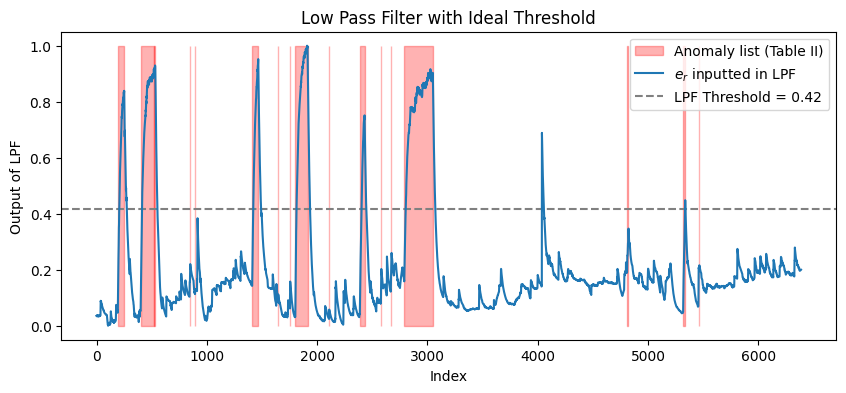

In [15]:
# Function to compute F1-score for a given threshold
def compute_f1_for_threshold(threshold):
    predicted_anomalies = (lpf_output_normalized >= threshold).astype(int)
    return f1_score(anomaly_list_binary, predicted_anomalies), predicted_anomalies

# Search for the best threshold
thresholds = np.linspace(0, 1, 10000)
best_threshold = max(thresholds, key=lambda t: compute_f1_for_threshold(t)[0])
best_f1, best_predictions = compute_f1_for_threshold(best_threshold)

# Compute confusion matrix
conf_matrix = confusion_matrix(anomaly_list_binary, best_predictions)

# Display results
print(f"Optimal Threshold: {best_threshold:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy = {}%".format(100*accuracy_score(anomaly_list_binary, best_predictions)))
print("Precision = {}%".format(100*precision_score(anomaly_list_binary, best_predictions, pos_label=1)))
print("Recall = {}%".format(100*recall_score(anomaly_list_binary, best_predictions, pos_label=1)))
print("F1 Score = {}%".format(100*f1_score(anomaly_list_binary, best_predictions, pos_label=1)))

# Plot the original and filtered data
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[aux_index:])), 0, 1, where=np.array(anomaly_list[aux_index:]) == 1, color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.axhline(y=best_threshold, color='gray', linestyle='--')
plt.plot(lpf_output_normalized, label="$e_r$ inputted in LPF", linestyle='-')
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label=f"LPF Threshold = {best_threshold:.2f}")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')
plt.title('Low Pass Filter with Ideal Threshold')
#plt.ylim(0,0.11)
plt.xlabel('Index')
plt.ylabel('Output of LPF')
plt.show()

In [16]:
len(np.where(lpf_output_normalized<best_threshold)[0])-5543

112

In [17]:
test_data_normalized[0]

array([0.846024  , 0.9614004 , 0.9580257 , 0.9133094 , 0.87112415,
       0.83062637, 0.7951909 , 0.9370848 , 0.96522075, 0.57756937,
       0.57405233, 0.00273544, 0.00273544, 0.00273544, 0.01575548,
       0.01358608], dtype=float32)

## Summary of Results

<table>
  <tr>
    <th>Metric</th>
    <th>LPF Output (fixed threshold)</th>
    <th>LPF Output (ideal threshold)</th>
    <th>Test Losses (ideal threshold)</th>
  </tr>
  <tr>
    <td colspan="4" style="border-bottom: double;"></td>
  </tr>
  <tr>
    <th>TP</th><td>623</td><td>579</td><td>676</td>
  </tr>
  <tr>
    <th>FP</th><td>276</td><td>151</td><td>118</td>
  </tr>
  <tr>
    <th>TN</th><td>5418</td><td>5543</td><td>5576</td>
  </tr>
  <tr>
    <th>FN</th><td>71</td><td>115</td><td>18</td>
  </tr>
  <tr>
    <td colspan="4" style="border-bottom: double;"></td>
  </tr>
  <tr>
    <th>Accuracy (%)</th><td>94.57</td><td>95.84</td><td>97.87</td>
  </tr>
  <tr>
    <th>Precision (%)</th><td>69.30</td><td>79.32</td><td>85.14</td>
  </tr>
  <tr>
    <th>Recall (%)</th><td>89.77</td><td>83.43</td><td>97.41</td>
  </tr>
  <tr>
    <th>F1 Score (%)</th><td>78.22</td><td>81.32</td><td>90.86</td>
  </tr>
</table>


## Feature Importance - SHAP Analysis

In [18]:
'''import shap
import numpy as np

# Ensure SHAP is installed
# !pip install shap

# Use the normalized test data as the background dataset
background_data = normal_train_data_normalized[:2]  # Use a subset of the training data as background

# Initialize the SHAP explainer
explainer = shap.KernelExplainer(autoencoder.predict, background_data)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(test_data_normalized)

# Check the shapes of shap_values and test_data_normalized
print(f"Shape of SHAP values: {np.array(shap_values).shape}")
print(f"Shape of test_data_normalized: {test_data_normalized.shape}")

# Ensure shap_values is a 2D array with the same number of rows as test_data_normalized
if len(np.array(shap_values).shape) == 3:
    shap_values = np.array(shap_values).mean(axis=0)  # Reduce to 2D if necessary

# Ensure the number of rows matches
assert shap_values.shape[0] == test_data_normalized.shape[0], "SHAP values and test data must have the same number of rows!"

# Plot the SHAP values for the first sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], test_data_normalized[0])

# Summary plot for all features
shap.summary_plot(shap_values, test_data_normalized, feature_names=[f"Feature {i}" for i in range(16)])'''

'import shap\nimport numpy as np\n\n# Ensure SHAP is installed\n# !pip install shap\n\n# Use the normalized test data as the background dataset\nbackground_data = normal_train_data_normalized[:2]  # Use a subset of the training data as background\n\n# Initialize the SHAP explainer\nexplainer = shap.KernelExplainer(autoencoder.predict, background_data)\n\n# Compute SHAP values for the test data\nshap_values = explainer.shap_values(test_data_normalized)\n\n# Check the shapes of shap_values and test_data_normalized\nprint(f"Shape of SHAP values: {np.array(shap_values).shape}")\nprint(f"Shape of test_data_normalized: {test_data_normalized.shape}")\n\n# Ensure shap_values is a 2D array with the same number of rows as test_data_normalized\nif len(np.array(shap_values).shape) == 3:\n    shap_values = np.array(shap_values).mean(axis=0)  # Reduce to 2D if necessary\n\n# Ensure the number of rows matches\nassert shap_values.shape[0] == test_data_normalized.shape[0], "SHAP values and test data mu